# Implementazione: Agente Gatto e Topo (A*)

Questo notebook implementa la soluzione al problema di pathfinding "Gatto e Topo" come definito nella nostra precedente analisi di modellazione.

Implementeremo:
1.  Un `Ambiente` per gestire lo stato del mondo (griglia, muri, posizioni).
2.  Un `Agente` che utilizza A* per pianificare un percorso ottimale.
3.  Un loop di simulazione per eseguire il piano.

In [ ]:
import heapq  # Fondamentale per la Priority Queue (Frontiera) di A*
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from typing import Tuple, Dict, List, Optional

# Definiamo le nostre convenzioni
# Coordinate logiche: (x, y)
# Accesso Array/Numpy: [y, x] (riga, colonna)
Posizione = Tuple[int, int]

## 1. La Classe Ambiente (Labirinto)

Questa classe gestisce lo stato del mondo. Non sa nulla di A*, si occupa solo di:
- Tenere traccia dei muri.
- Sapere dove sono Gatto e Topo.
- Calcolare l'esito di un'azione (transizione).
- Visualizzarsi.

In [ ]:
class AmbienteLabirinto:
    def __init__(self, size=10):
        self.size = size
        # 0 = Libero, 1 = Muro
        self.grid = np.zeros((size, size), dtype=int)
        self.cat_pos: Posizione = (0, 0)
        self.mouse_pos: Posizione = (size - 1, size - 1)
        self.topo_mangiato = False

    def set_positions(self, cat_pos: Posizione, mouse_pos: Posizione):
        self.cat_pos = cat_pos
        self.mouse_pos = mouse_pos

    def add_wall(self, x: int, y: int):
        if 0 <= x < self.size and 0 <= y < self.size:
            self.grid[y, x] = 1 # NB: accesso [y, x]
    def add_vertical_wall(self, x, y_start, length):
        for y in range(y_start, y_start + length):
            self.add_wall(x, y)

    def add_horizontal_wall(self, y, x_start, length):
        for x in range(x_start, x_start + length):
            self.add_wall(x, y)

    def is_valid_position(self, pos: Posizione) -> bool:
        x, y = pos
        if not (0 <= x < self.size and 0 <= y < self.size):
            return False
        if self.grid[y, x] == 1: # Muro
            return False
        return True

    def get_transition_result(self, pos: Posizione, action: str) -> Posizione:
        x, y = pos
        if action == 'N':
            new_pos = (x, y - 1)
        elif action == 'S':
            new_pos = (x, y + 1)
        elif action == 'E':
            new_pos = (x + 1, y)
        elif action == 'W':
            new_pos = (x - 1, y)
        else:
            new_pos = pos

        if self.is_valid_position(new_pos):
            return new_pos
        else:
            return pos # L'azione fallisce, l'agente resta fermo

    def check_goal(self) -> bool:
        if self.cat_pos == self.mouse_pos:
            self.topo_mangiato = True
            return True
        return False

    def get_perception(self) -> Dict:
        # In ambiente 'fully observable', l'agente ottiene tutto
        return {
            "cat_pos": self.cat_pos,
            "mouse_pos": self.mouse_pos,
            "grid_map": self.grid,
            "size": self.size
        }

    def visualize(self, path: Optional[List[Posizione]] = None):
        # 0=Libero, 1=Muro, 2=Percorso
        display_grid = np.copy(self.grid)

        if path:
            for (x, y) in path:
                if display_grid[y, x] == 0:
                    display_grid[y, x] = 2 # Percorso

        # DON'T color cat/mouse cells in the grid array; we will overlay icons instead
        mouse_x, mouse_y = self.mouse_pos
        display_grid[mouse_y, mouse_x] = 3
        cat_x, cat_y = self.cat_pos
        display_grid[cat_y, cat_x] = 4

        # Colori di base: 0=Bianco, 1=Nero (muri), 2=Giallo (percorso), 3=Bianco (Topo), 4=Bianco (Gatto)
        cmap = ListedColormap(['#FFFFFF', '#222222', '#FFEE00', '#FFFFFF', '#FFFFFF'])
        
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(display_grid, cmap=cmap, interpolation='nearest')

        # Icone/etichette per topo e gatto (emoji con fallback marker)
        fontsize = max(14, int(24 * (10 / max(6, self.size))))

        # Draw mouse first (below cat)
        try:
            ax.text(mouse_x, mouse_y, '🐭', ha='center', va='center', fontsize=fontsize, zorder=5)
        except Exception:
            ax.scatter([mouse_x], [mouse_y], s=200, marker='o', color='#00FF00', edgecolors='k', zorder=5)

        # Draw cat on top
        try:
            ax.text(cat_x, cat_y, '🐱', ha='center', va='center', fontsize=fontsize, zorder=6)
        except Exception:
            ax.scatter([cat_x], [cat_y], s=200, marker='P', color='#0000FF', edgecolors='k', zorder=6)

        # Griglia e ticks
        ax.set_xticks(np.arange(self.size))
        ax.set_yticks(np.arange(self.size))
        ax.set_xticks(np.arange(-.5, self.size, 1), minor=True)
        ax.set_yticks(np.arange(-.5, self.size, 1), minor=True)
        ax.grid(which='minor', color='k', linestyle='-', linewidth=1)
        ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

        plt.title("Stato del Labirinto")
        plt.show()

## 2. La Classe Agente (Gatto)

Questa è la parte "intelligente". Questa classe:
- Mantiene uno stato interno (il piano).
- Implementa l'euristica (Manhattan).
- Implementa l'algoritmo **A*** (il cuore).
- Ricostruisce il piano in una sequenza di azioni.

In [ ]:
class AgenteGatto:
    def __init__(self):
        self.position: Posizione
        self.goal_position: Posizione
        self.grid_map: #definire
        self.size: int
        self.plan: list[str]
        pass
       
    def get_next_action(self, perception: Dict) -> Optional[str]:
        self.position = perception.cat_pos
        self.goal_position = perception.mouse_pos
        self.grid_map = perception.grid_map
        self.size = perception.size

        if len(self.plan) != 0:
            #restituisci prima azione del piano
            #se il piano fA una sequenza di mosse da dove si rova il gatto fino al topo
            next_action=self.plan.pop(0)
            #se il piano fA una sequenza a ritroso
            #next_action = self.plan.pop(-1)
            return next_action
        else:
            #costruisci piano
            self.plan = self.Astar()
            return None

        def Astar(self)-> list[str]:
            pass
        def manhattan_distance(point1: Posizione, point2: Posizione)->int:
            return abs(point1[0] - point2[0]) + abs(point1[1] - pint2[1])
        pass

    
    

## 3. Setup della Simulazione

Creiamo le istanze, definiamo il labirinto e prepariamo la simulazione.

--- Labirinto Iniziale (size=11, cat_side=left, CAT_START=(1, 9), MOUSE_GOAL=(5, 4)) ---


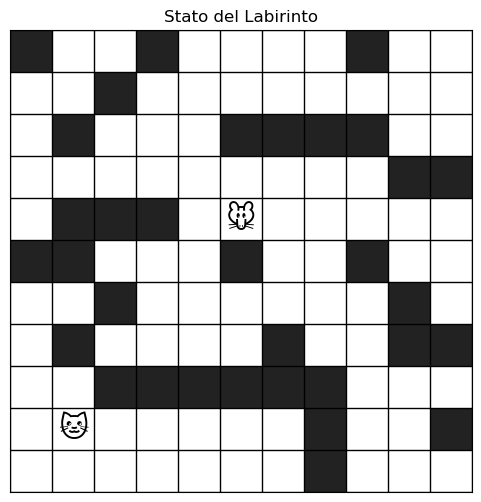

In [ ]:
# 1. Creazione Istanze (random environment con conoscenza di dominio)
# - Il Gatto e il Topo devono stare in metà diverse del labirinto (metà verticali)
# - Riduciamo la densità dei muri della metà rispetto alla versione precedente
# Nota: non eseguiamo più il check di esistenza del percorso (nessuna chiamata A*)
# In questo modo l'ambiente è casuale ma rispetta la vincolo di metà diverse
# Creiamo dimensione casuale tra 6 e 14
size = int(np.random.randint(6, 15))
env = AmbienteLabirinto(size=size)
agent = AgenteGatto()

# Determiniamo la linea di demarcazione verticale (metà sinistra / destra)
half_x = size // 2
# Scegliamo se mettere il gatto a sinistra e il topo a destra o viceversa
if np.random.rand() < 0.5:
    cat_side = 'left'
    mouse_side = 'right'
else:
    cat_side = 'right'
    mouse_side = 'left'

def sample_in_side(side):
    if side == 'left':
        x = int(np.random.randint(0, max(1, half_x)))
    else:
        x = int(np.random.randint(half_x, size))
    y = int(np.random.randint(0, size))
    return (x, y)

CAT_START = sample_in_side(cat_side)
MOUSE_GOAL = sample_in_side(mouse_side)
# Nel raro caso (size small) in cui le funzioni ritornino la stessa posizione, risampiamo il topo
while MOUSE_GOAL == CAT_START:
    MOUSE_GOAL = sample_in_side(mouse_side)

env.set_positions(CAT_START, MOUSE_GOAL)

# Muri casuali: metà della densità precedente
base_wall_prob = min(0.45, 0.18 + 0.02 * size)
wall_prob = base_wall_prob * 0.5
for x in range(size):
    for y in range(size):
        if (x, y) == CAT_START or (x, y) == MOUSE_GOAL:
            continue
        if np.random.rand() < wall_prob:
            env.add_wall(x, y)

# Aggiungiamo occasionalmente qualche muro lungo segmenti casuali (probabilità ridotta)
if np.random.rand() < 0.35:
    x = int(np.random.randint(0, size))
    y_start = int(np.random.randint(0, max(1, size//2)))
    length = int(min(size - y_start, max(1, np.random.randint(1, size))))
    env.add_vertical_wall(x=x, y_start=y_start, length=length)
if np.random.rand() < 0.35:
    y = int(np.random.randint(0, size))
    x_start = int(np.random.randint(0, max(1, size//2)))
    length = int(min(size - x_start, max(1, np.random.randint(1, size))))
    env.add_horizontal_wall(y=y, x_start=x_start, length=length)

# 3. Visualizzazione Iniziale
print(f"--- Labirinto Iniziale (size={size}, cat_side={cat_side}, CAT_START={CAT_START}, MOUSE_GOAL={MOUSE_GOAL}) ---")
env.visualize()

## 4. Esecuzione del Loop di Simulazione

Facciamo "correre" il Gatto. L'ambiente chiede un'azione, l'agente (pianifica e) risponde.


--- Avvio Simulazione ---
Agente: Piano vuoto. Avvio pianificazione A*...
Agente: Piano trovato! Lunghezza: 14 passi.
Passo 0: Posizione Gatto (9, 3), Azione scelta: W


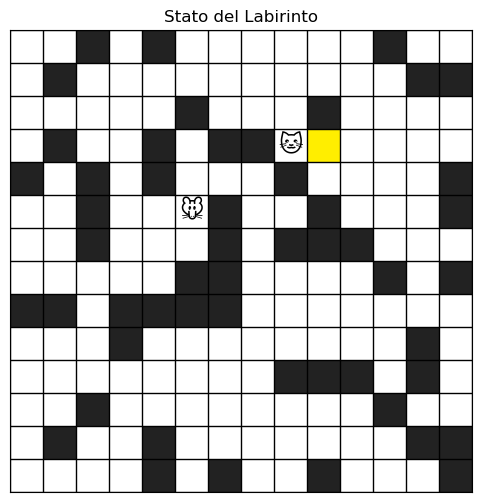

Passo 1: Posizione Gatto (8, 3), Azione scelta: N


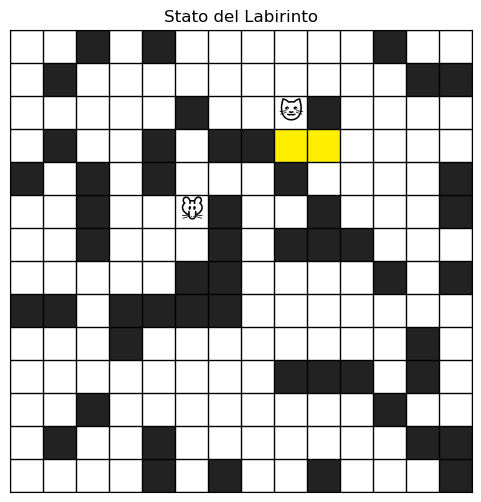

Passo 2: Posizione Gatto (8, 2), Azione scelta: W


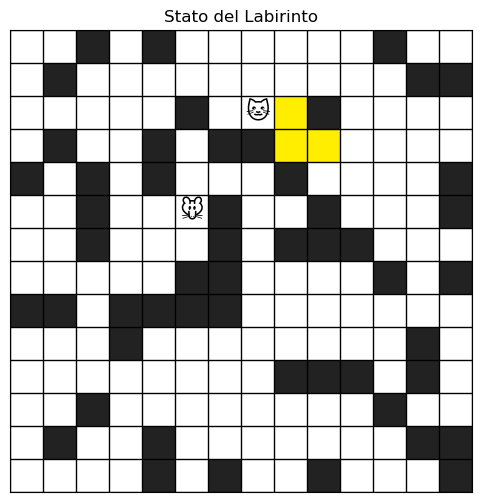

Passo 3: Posizione Gatto (7, 2), Azione scelta: W


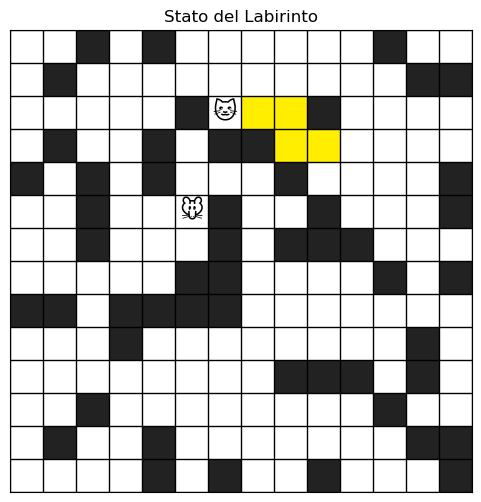

Passo 4: Posizione Gatto (6, 2), Azione scelta: N


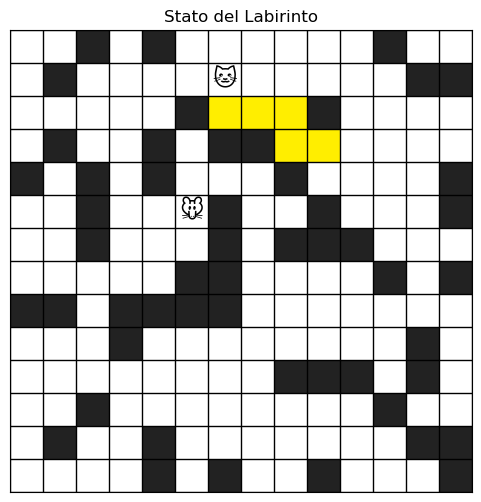

Passo 5: Posizione Gatto (6, 1), Azione scelta: W


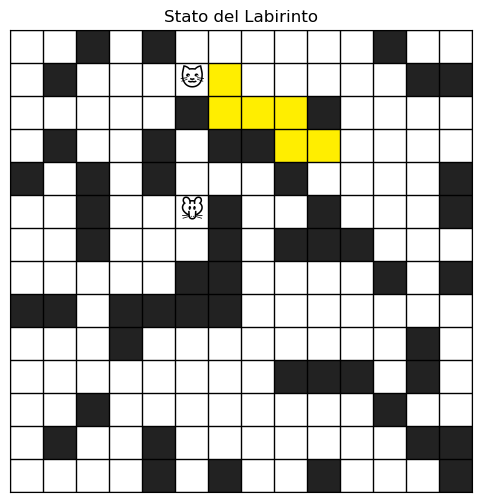

Passo 6: Posizione Gatto (5, 1), Azione scelta: W


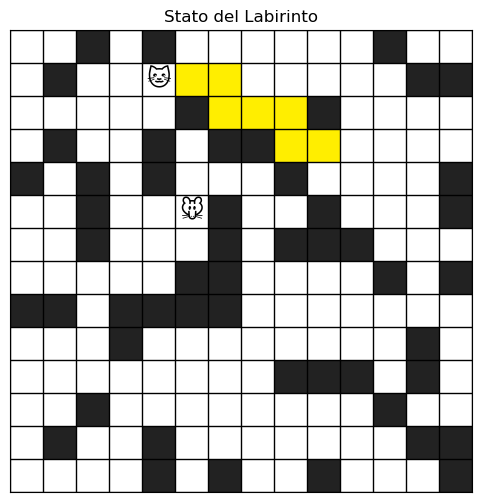

Passo 7: Posizione Gatto (4, 1), Azione scelta: S


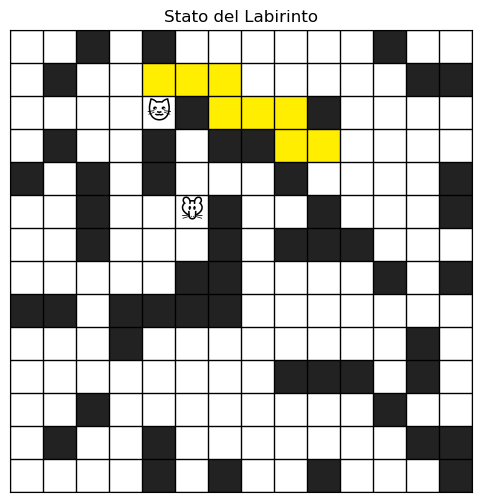

Passo 8: Posizione Gatto (4, 2), Azione scelta: W


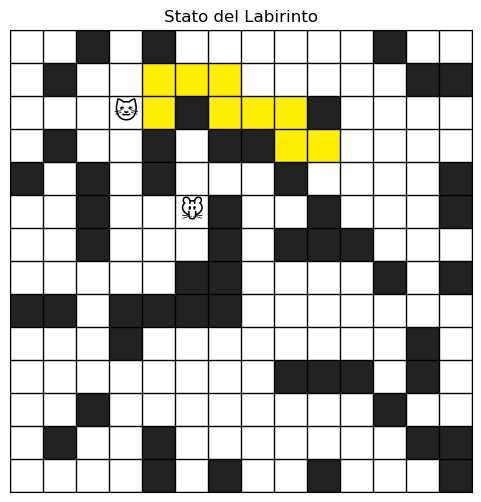

Passo 9: Posizione Gatto (3, 2), Azione scelta: S


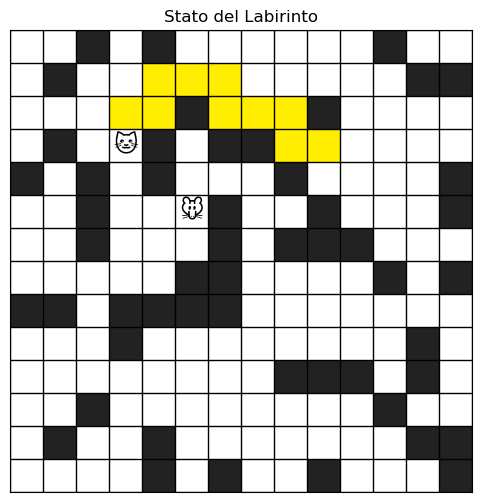

Passo 10: Posizione Gatto (3, 3), Azione scelta: S


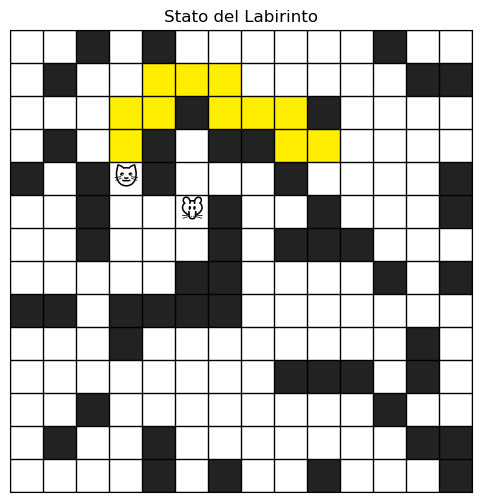

Passo 11: Posizione Gatto (3, 4), Azione scelta: S


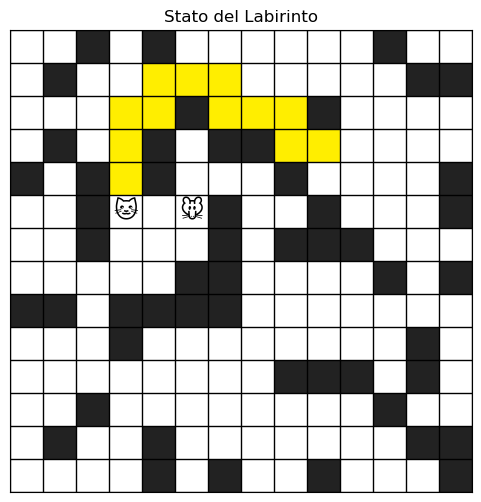

Passo 12: Posizione Gatto (3, 5), Azione scelta: E


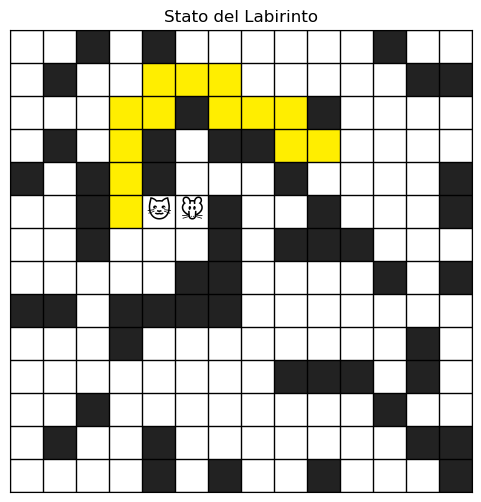

Passo 13: Posizione Gatto (4, 5), Azione scelta: E


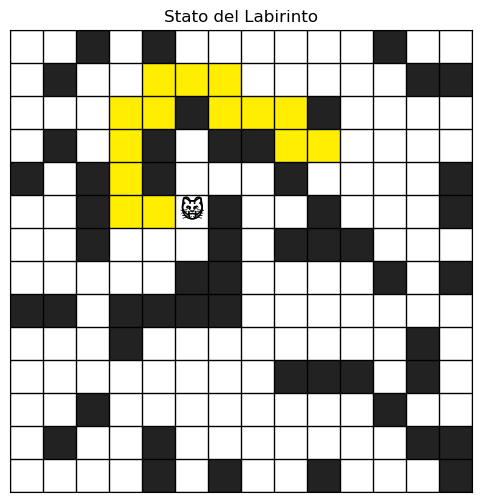


+++ OBIETTIVO RAGGIUNTO al passo 14 alla posizione (5, 5) +++


In [ ]:
path_taken = [CAT_START] # Tracciamo il percorso reale
max_steps = 100
goal_reached = False

print("\n--- Avvio Simulazione ---")

for step in range(max_steps):
    # 1. L'agente percepisce l'ambiente
    perception = env.get_perception()
    
    # 2. L'agente decide l'azione
    action = agent.get_next_action(perception)
    
    if action is None:
        print(f"Passo {step}: L'agente non ha più azioni o non trova un percorso. Termino.")
        break
    
    # 3. L'ambiente calcola la transizione
    print(f"Passo {step}: Posizione Gatto {env.cat_pos}, Azione scelta: {action}")
    new_cat_pos = env.get_transition_result(env.cat_pos, action)
    env.cat_pos = new_cat_pos
    path_taken.append(new_cat_pos)
    # Visualizziamo lo stato del mondo ad ogni iterazione (mostriamo anche il percorso finora)
    env.visualize(path=path_taken)
    
    # 4. Controllo Goal
    if env.check_goal():
        print(f"\n+++ OBIETTIVO RAGGIUNTO al passo {step + 1} alla posizione {env.cat_pos} +++")
        goal_reached = True
        break

if not goal_reached:
    print(f"--- Simulazione terminata (raggiunto limite max_steps: {max_steps}) ---")

## 5. Risultati e Visualizzazione Finale

Calcoliamo le metriche di performance e mostriamo il percorso finale trovato.


--- Report Finale ---
Posizione Iniziale (Gatto): (9, 3)
Posizione Finale (Topo):   (5, 5)
Costo percorso A* (passi):  14
Costo ideale (Manhattan):   6
Indice di Sinuosità:        2.33

--- Mappa del Percorso Trovato ---


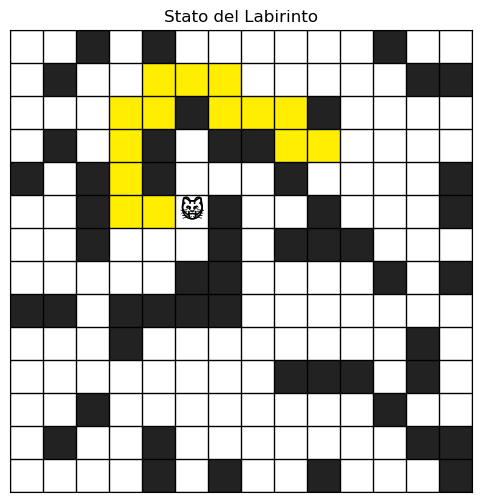

In [ ]:
print("\n--- Report Finale ---")

# Calcoliamo la performance
if goal_reached:
    costo_reale = len(path_taken) - 1
    costo_ideale = agent.heuristic(CAT_START, MOUSE_GOAL) # Manhattan

    print(f"Posizione Iniziale (Gatto): {CAT_START}")
    print(f"Posizione Finale (Topo):   {MOUSE_GOAL}")
    print(f"Costo percorso A* (passi):  {costo_reale}")
    print(f"Costo ideale (Manhattan):   {costo_ideale}")
    
    if costo_ideale > 0:
        indice_sinuosita = costo_reale / costo_ideale
        print(f"Indice di Sinuosità:        {indice_sinuosita:.2f}")
    else:
        print("Indice di Sinuosità: N/A (Start = Goal)")

    # 2. Visualizzazione Finale
    print("\n--- Mappa del Percorso Trovato ---")
    env.visualize(path=path_taken)
else:
    print("Obiettivo non raggiunto.")
    env.visualize()